# Рынок BMW

## Описание

Для простоты рассмотрим рынок BMW, выпущенных после 2010 года. Данные берутся с 3 наиболее популярных сайтов по продаже авто в России — Авто.ру, Авито, Дром

## Сбор данных

Так как каждый сайт имеет свой HTML-код, то код для парсинга каждого сайта будет отличаться. Используется динамический парсинг с помощью Selenium

### Основные критерии

- Модель
- Год выпуска
- Объем двигателя
- Бензин/дизель
- Привод
- Мощность (л.с.)
- Пробег
- КПП
- Цена
- Тип (седан/внедорожник/кроссовер) (???)


In [26]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import importlib
import auto_ru_parse
importlib.reload(auto_ru_parse)
import auto_ru_parse
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd

### Парсинг с Авто.ру

In [5]:
class Auto:
    def __init__(self, model: str = "", gen: str = "", year: int = 0, engine_volume: float = 0.0, fuel_type: str = "",
                 drive: str = "", power_hp: int = 0, mileage: int = 0, transmission: str = "", price: int = 0, url: str = ""):
        self.model = model                      # модель
        self.gen = gen                          # серия
        self.year = year                        # год выпуска
        self.engine_volume = engine_volume      # объем двигателя
        self.fuel_type = fuel_type              # бензин/дизель
        self.drive = drive                      # привод
        self.power_hp = power_hp                # мощность в л.с.
        self.mileage = mileage                  # пробег (==0, если новая)
        self.transmission = transmission        # КПП
        self.price = price                      # цена
        self.url = url                          # ссылка на сайт

    def __str__(self):
        return (f"{self.model} | {self.gen} | {self.year} | {self.mileage} |{self.engine_volume}L | {self.power_hp} HP | {self.fuel_type} | "
                f"{self.transmission} | {self.drive} | {self.price} ₽ | {self.url}")


In [6]:
num_pages = 100                     # кол-во страниц, которые хоти обработать
year = 2010                         # самый ранний год выпуска машины
non_dymanic = True                  # если нужно, чтобы браузер НЕ открывался в явном виде, то поставить True

In [7]:
htmls = auto_ru_parse.parse_html(year, num_pages, non_dymanic)

Error sending stats to Plausible: error sending request for url (https://plausible.io/api/event)


In [8]:
cars = auto_ru_parse.collect_data(htmls)

In [10]:
for car in cars:
    auto_ru_parse.modify_gen(car)
    # print(car)

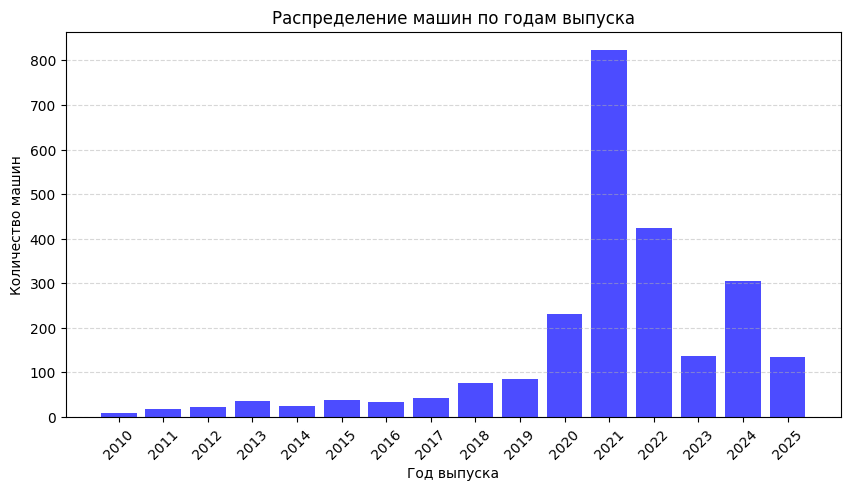

In [12]:
years = [car.year for car in cars]

year_counts = Counter(years)

x = sorted(year_counts.keys())
y = [year_counts[year] for year in x]

plt.figure(figsize=(10, 5))
plt.bar(x, y, color='blue', alpha=0.7)
plt.xlabel("Год выпуска")
plt.ylabel("Количество машин")
plt.title("Распределение машин по годам выпуска")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

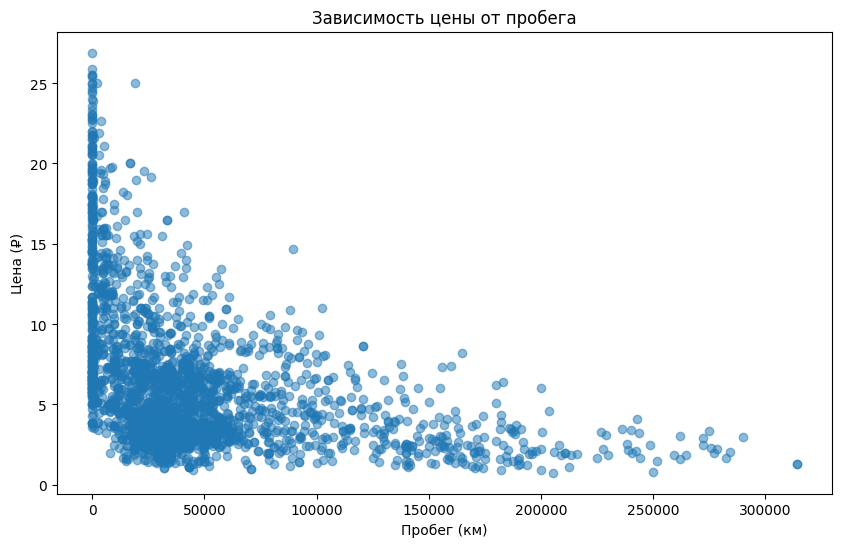

Корреляция между ценой и пробегом: -0.41


In [13]:
mileages = [int(car.mileage) for car in cars]
prices = [car.price / 1000000 for car in cars]

plt.figure(figsize=(10, 6))
plt.scatter(mileages, prices, alpha=0.5)
plt.xlabel("Пробег (км)")
plt.ylabel("Цена (₽)")
plt.title("Зависимость цены от пробега")

plt.show()

correlation = np.corrcoef(mileages, prices)[0, 1]

print(f"Корреляция между ценой и пробегом: {round(correlation, 2)}")

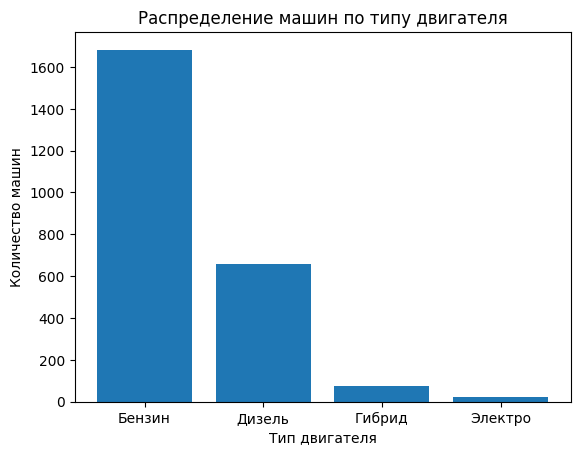

In [14]:
fuel_counts = Counter(car.fuel_type for car in cars)

plt.bar(fuel_counts.keys(), fuel_counts.values())
plt.xlabel("Тип двигателя")
plt.ylabel("Количество машин")
plt.title("Распределение машин по типу двигателя")
plt.show()

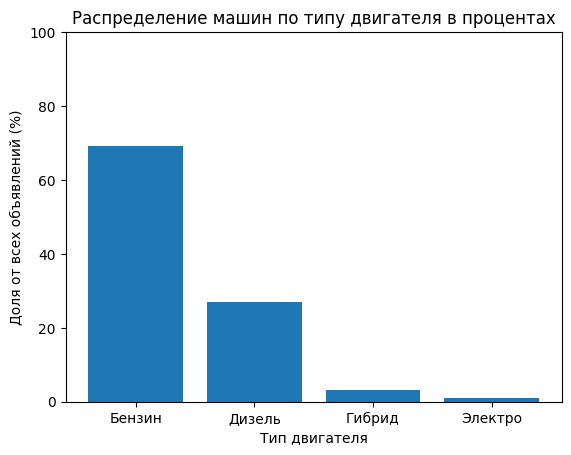

In [15]:
total_cars = len(cars)
fuel_counts = Counter(car.fuel_type for car in cars)
fuel_percentages = {key: (value / total_cars) * 100 for key, value in fuel_counts.items()}

plt.bar(fuel_percentages.keys(), fuel_percentages.values())
plt.xlabel("Тип двигателя")
plt.ylabel("Доля от всех объявлений (%)")
plt.title("Распределение машин по типу двигателя в процентах")
plt.ylim(0, 100)
plt.show()

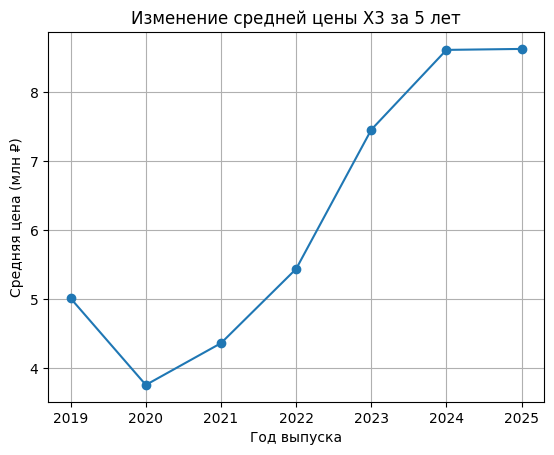

In [16]:
most_popular = Counter(car.gen for car in cars).most_common(1)[0][0]

filtered_cars = [car for car in cars if car.gen == most_popular]
years = sorted(set(car.year for car in filtered_cars if int(car.year) >= 2019))

avg_prices = [sum(car.price for car in filtered_cars if car.year == year) /
              sum(1 for car in filtered_cars if car.year == year) for year in years]
avg_prices = [price / 1_000_000 for price in avg_prices] 

plt.plot(years, avg_prices, marker='o')
plt.xlabel("Год выпуска")
plt.ylabel("Средняя цена (млн ₽)")
plt.title(f"Изменение средней цены {most_popular} за 5 лет")
plt.grid()
plt.show()

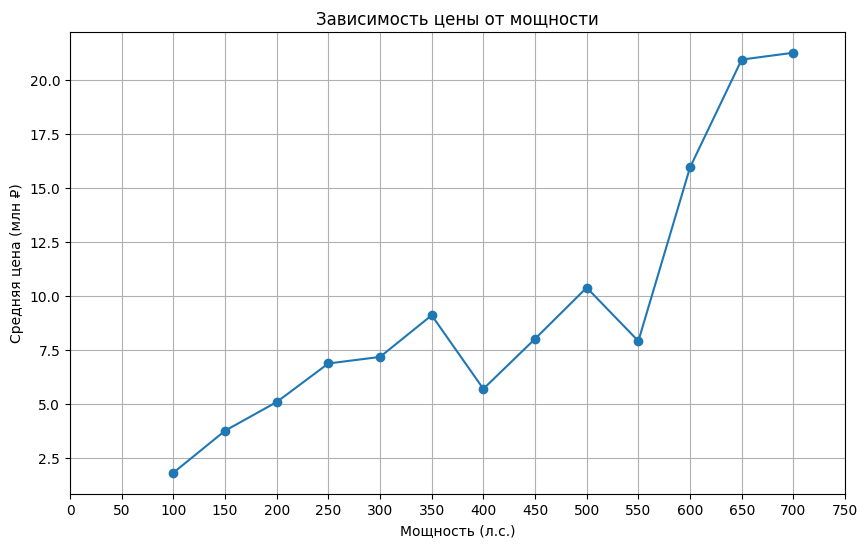

In [17]:
power_bins = range(0, max(car.power_hp for car in cars) + 50, 50)

# Группируем данные
power_avg_price = {}
for power in power_bins:
    cars_in_bin = [car.price for car in cars if power <= int(car.power_hp) < power + 50]
    if cars_in_bin:
        power_avg_price[power] = sum(cars_in_bin) / len(cars_in_bin) / 1_000_000 

powers = sorted(power_avg_price.keys())
avg_prices = [power_avg_price[p] for p in powers]

plt.figure(figsize=(10,6))
plt.plot(powers, avg_prices, marker='o', linestyle='-')
plt.xlabel("Мощность (л.с.)")
plt.ylabel("Средняя цена (млн ₽)")
plt.title("Зависимость цены от мощности")
plt.grid()

plt.xticks(power_bins)  

plt.show()

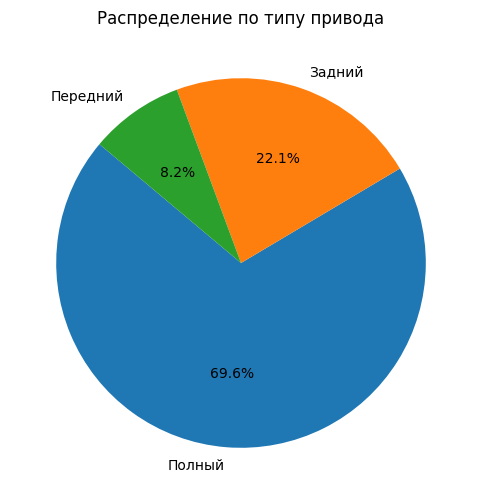

In [18]:
drive_mapping = {
    "передний": "Передний",
    "задний": "Задний",
    "4WD": "Полный",
    "полный": "Полный"
}

drive_types = [drive_mapping.get(car.drive, "Другой") for car in cars]
drive_counts = Counter(drive_types)

labels = drive_counts.keys()
sizes = drive_counts.values()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Распределение по типу привода")
plt.show()

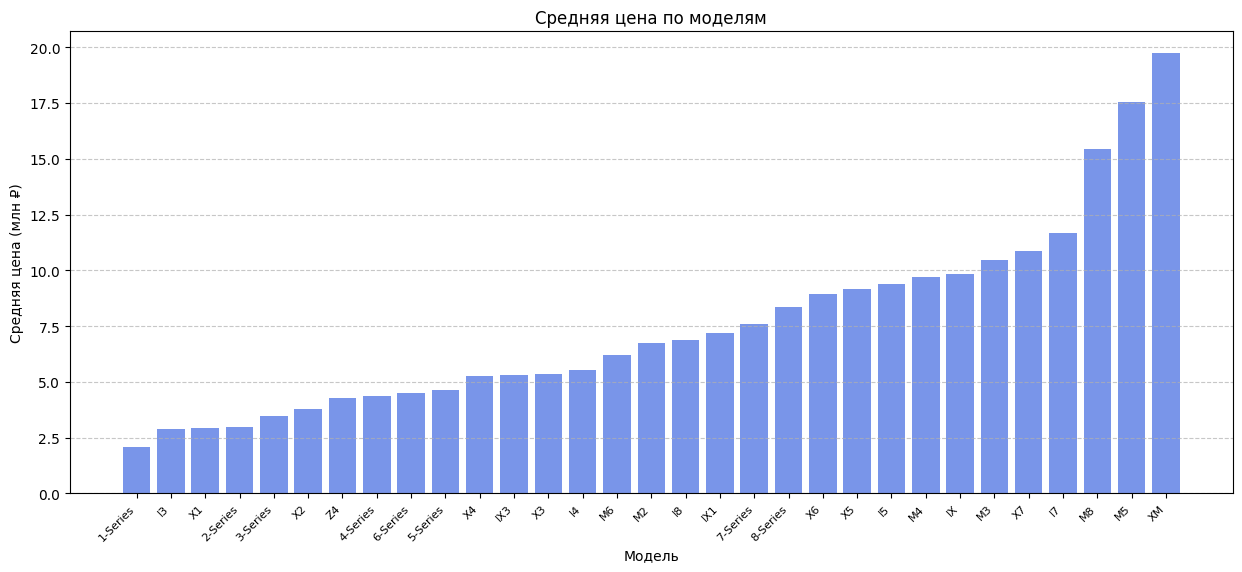

In [19]:
model_prices = {}
model_counts = Counter(car.gen for car in cars)

for model in model_counts:
    filtered = [car.price for car in cars if car.gen == model]
    if filtered:
        model_prices[model] = sum(filtered) / len(filtered)

sorted_models = sorted(model_prices.keys(), key=lambda x: model_prices[x], reverse=False)
sorted_avg_prices = [model_prices[model] / 1_000_000 for model in sorted_models]

plt.figure(figsize=(15, 6))
plt.bar(sorted_models, sorted_avg_prices, color='royalblue', alpha=0.7)
plt.xticks(rotation=45, ha="right", fontsize=8) 
plt.xlabel("Модель")
plt.ylabel("Средняя цена (млн ₽)")
plt.title("Средняя цена по моделям")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [28]:
df = auto_ru_parse.cars_list_to_dataframe(cars)

df


,Модель,Серия,Год,Объем двигателя (л),Топливо,Привод,Мощность (л.с.),Пробег (км),КПП,Цена (₽),Ссылка
0,BMW X6 40i III (G06) Рестайлинг,X6,2024,3.0,Бензин,полный,381,34,автомат,10650048,https://auto.ru/cars/used/sale/bmw/x6/11274063...
1,BMW X3 20d xDrive III (G01),X3,2021,2.0,Дизель,полный,190,42000,автомат,3300000,https://auto.ru/cars/used/sale/bmw/x3/11267363...
2,BMW M3 Competition Package VI (G80) Рестайлинг,M3,2024,3.0,Бензин,полный,530,4394,автомат,12000000,https://auto.ru/cars/used/sale/bmw/m3/11275091...
3,BMW X1 Long 25Li xDrive II (F48) Рестайлинг,X1,2022,2.0,Бензин,полный,192,22321,автомат,2000002,https://auto.ru/cars/used/sale/bmw/x1/11273554...
4,BMW X6 40i III (G06),X6,2021,3.0,Бензин,полный,340,50000,автомат,5800755,https://auto.ru/cars/used/sale/bmw/x6/11274737...
...,...,...,...,...,...,...,...,...,...,...,...
2433,BMW X4 20i II (G02) Рестайлинг,X4,2023,2.0,Бензин,полный,184,16200,автомат,5800000,https://auto.ru/cars/used/sale/bmw/x4/11274114...
2434,BMW X3 30i xDrive III (G01) Рестайлинг,X3,2021,2.0,Бензин,полный,249,33000,автомат,3540097,https://auto.ru/cars/used/sale/bmw/x3/11274633...
2435,BMW X3 M Competition I (F97) Рестайлинг,X3,2024,3.0,Бензин,полный,510,9550,автомат,9980000,https://auto.ru/cars/used/sale/bmw/x3_m/112723...
2436,BMW X3 20i xDrive III (G01) Рестайлинг,X3,2021,2.0,Бензин,полный,184,24000,автомат,3480500,https://auto.ru/cars/used/sale/bmw/x3/11267991...


In [29]:
df.to_csv("cars.csv", index=False, encoding="utf-8-sig")